# Simple analysis of developer_survey data

*Disclaimer:* This notebook provides a simple analysis of the publicly available "stackoverflow survey data" (which can be found [here](https://insights.stackoverflow.com/survey)) to create a rudimentary model to predict the yearly income of various technical jobs based on age, experience, and activities. Subsequently, we use this model to demonstrate the ease-of-use of [Scailable](https://www.scailable.net) for putting models in production.

The data cleaning process, as well as the created model, are **rudimentary**; the current notebook does not aim to provide a thorough analysis of the survey data nor do we claim that the resulting model is, at all, accurate in predicting salaries. Actually, it should be relatively easy to improve upon the model we present here and we leave that up to the reader. 

The aim of the current document is to showcase the simple deployment functionality of fitted models directly from `python` provided by [Scailable](https://www.scailable.net); feel free to improve the presented model and open up your own endpoint!

This document supports the [Scailable 101 - getting started demo](https://github.com/scailable/sclbl-tutorials/tree/master/sclbl-101-getting-started).

## Preliminaries
We first install some of the packages neccesary; skip this step if you have these already. 

In [1]:
# Install packages, uncomment if you still need any of these...

#!pip3 install numpy
#!pip3 install pandas
#!pip3 install sklearn
#!pip3 install matplotlib

Next, we open the data:

In [1]:
# Import neccesary packages for data cleaning and plotting
import pandas as pd
import matplotlib.pyplot as plt

# Unzip the file (as it was too big to upload to github)
from zipfile import ZipFile
with ZipFile("developer_survey_2019/survey_results_public.csv.zip", 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall("data")

In [9]:
# Import the data file
df = pd.read_csv("data/survey_results_public.csv")

In [10]:
# Print its initial shape
print(df.shape)

# And the columns
print(list(df))

(88883, 85)
['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource', 'Employment', 'Country', 'Student', 'EdLevel', 'UndergradMajor', 'EduOther', 'OrgSize', 'DevType', 'YearsCode', 'Age1stCode', 'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobSeek', 'LastHireDate', 'LastInt', 'FizzBuzz', 'JobFactors', 'ResumeUpdate', 'CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq', 'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev', 'CodeRevHrs', 'UnitTests', 'PurchaseHow', 'PurchaseWhat', 'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith', 'PlatformDesireNextYear', 'WebFrameWorkedWith', 'WebFrameDesireNextYear', 'MiscTechWorkedWith', 'MiscTechDesireNextYear', 'DevEnviron', 'OpSys', 'Containers', 'BlockchainOrg', 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn', 'SocialMedia', 'Extraversion', 'ScreenName', 'SOVisit1st', 'SOVisitFr

## Cleaning and feature engineering
We are interested in predicting the yearly salary (in the variable `ConvertedComp`), but this contains zero's, missings, and some -- we would say -- implausible values. So, we clean it up.

Next, we create the features we are interested in for predicting the yearly salary. These are:

* `OpenSourcer`
* `Employment`
* `EdLevel`
* `OrgSize`
* `DevType`
* `YearsCode`
* `YearsCodePro`
* `MgrWant`
* `LanguageWorkedWith`
* `Age`
* `Gender`

> Note: This is a somewhat arbitrary subset of variables, but these might work well for a first model; please feel free to extend!

### Main outcome: Yearly income
First, we somewhat clean up the `ConvertedComp` variable which should describe the standardized yearly income. We remove NAs, 0s, and the few very high values as these seem to be outliers.

In [11]:
# Drop 0 and NA:
df = df[(df['ConvertedComp'] > 0)]
df = df.dropna(subset=['ConvertedComp'])

# Drop > 999999
df = df[(df['ConvertedComp'] < 999999)]

# So, we now have:
print(df.shape)

(53948, 85)


(array([14757., 12464., 10288.,  6222.,  3553.,  2184.,  1060.,   684.,
          284.,   273.,   186.,   108.,   123.,    87.,   118.,    71.,
           90.,    67.,    80.,   103.,    62.,    71.,    98.,    89.,
           77.,    79.,    61.,    72.,   104.,    70.,    53.,    75.,
           59.,    61.,    76.,    39.]),
 array([1.00000000e+00, 2.77279722e+04, 5.54549444e+04, 8.31819167e+04,
        1.10908889e+05, 1.38635861e+05, 1.66362833e+05, 1.94089806e+05,
        2.21816778e+05, 2.49543750e+05, 2.77270722e+05, 3.04997694e+05,
        3.32724667e+05, 3.60451639e+05, 3.88178611e+05, 4.15905583e+05,
        4.43632556e+05, 4.71359528e+05, 4.99086500e+05, 5.26813472e+05,
        5.54540444e+05, 5.82267417e+05, 6.09994389e+05, 6.37721361e+05,
        6.65448333e+05, 6.93175306e+05, 7.20902278e+05, 7.48629250e+05,
        7.76356222e+05, 8.04083194e+05, 8.31810167e+05, 8.59537139e+05,
        8.87264111e+05, 9.14991083e+05, 9.42718056e+05, 9.70445028e+05,
        9.98172000e+05

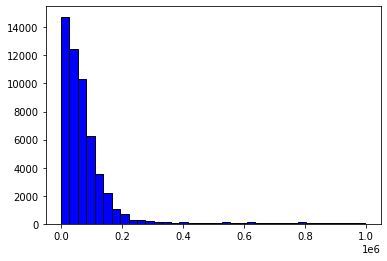

In [12]:
# Let's plot again
plt.hist(df['ConvertedComp'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

In [13]:
# and lets create a new variable with a more sensible name:
df['salary'] = df['ConvertedComp']

### Feature engineering
Next, we clean up the features of interest one by one, starting with `OpenSourcer`. This variable current has four levels (`Less than once a month but more than once per year`, `Less than once per year`, `Never`, and `Once a month or more often`). We will recode it such that a 1 indicates that a respondent often contributes to open source projects, 0 otherwise. 

> We will prefix the features we custom build by `f_`

In [14]:
# define
def open_dummy(series):
    if series == "Once a month or more often":
        return 1
    else:
        return 0

# recode:
df['f_open'] = df['OpenSourcer'].apply(open_dummy)

# inspect:
df['f_open'].value_counts(sort=False)

0    47782
1     6166
Name: f_open, dtype: int64

We will change `Employment` to indicate `employed`, `selfemployed`, or `unemployed` and create dummies.

In [15]:
# define
def employment_status(series):
    if series == "Employed full-time" or series == "Employed part-time":
        return "f_employed"
    elif series == "Independent contractor, freelancer, or self-employed":
        return "f_selfemployed"
    else:
        return "f_unemployed"

# recode:
df['employmentStatus'] = df['Employment'].apply(employment_status)

# inspect:
print(df['employmentStatus'].value_counts(sort=False))

# create dummies:
employmentDummies = pd.get_dummies(df['employmentStatus'])
print(employmentDummies.head())

# add to df:
df = df.join(employmentDummies)
print(list(df))

f_unemployed        129
f_employed        49439
f_selfemployed     4380
Name: employmentStatus, dtype: int64
   f_employed  f_selfemployed  f_unemployed
2           1               0             0
3           1               0             0
5           1               0             0
8           1               0             0
9           1               0             0
['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource', 'Employment', 'Country', 'Student', 'EdLevel', 'UndergradMajor', 'EduOther', 'OrgSize', 'DevType', 'YearsCode', 'Age1stCode', 'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobSeek', 'LastHireDate', 'LastInt', 'FizzBuzz', 'JobFactors', 'ResumeUpdate', 'CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq', 'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev', 'CodeRevHrs', 'UnitTests', 'PurchaseHow', 'PurchaseWhat', 'LanguageWorkedWith', 'LanguageDesireNextYear', 'Data

Now lets look at `EdLevel` and recode...

In [16]:
# define
def education_level(series):
    if series == "Master’s degree (MA, MS, M.Eng., MBA, etc.)" or series == "Other doctoral degree (Ph.D, Ed.D., etc.)" or series == "Professional degree (JD, MD, etc.)":
        return 2
    elif series == "Bachelor’s degree (BA, BS, B.Eng., etc.)":
        return 1
    else:
        return 0

# recode:
df['f_education'] = df['EdLevel'].apply(education_level)

# inspect:
print(df['f_education'].value_counts(sort=False))

0    12107
1    26038
2    15803
Name: f_education, dtype: int64


Ok, now we are over to `OrgSize`... let's just to small `<500 employees` and large....

In [17]:
# define
def organization_size(series):
    if series == "500 to 999 employees" or series == "1,000 to 4,999 employees" or series == "5,000 to 9,999 employees" or series == "10,000 or more employees":
        return 1
    else:
        return 0

# recode:
df['f_organization'] = df['OrgSize'].apply(organization_size)

# inspect:
print(df['f_organization'].value_counts(sort=False))

0    35022
1    18926
Name: f_organization, dtype: int64


Ok, `DevType` is a bit more tricky as it contains multiple answers in a string that is comma-seperated. Let's pick out a few interesting ones: `datascientist`, `designer`, `developer`, `devops`, `engineer`, and `scientist`.

In [18]:
def datascience_present(series):
    if "Data scientist" in str(series):
        return 1
    else:
        return 0

def designer_present(series):
    if "Designer" in str(series):
        return 1
    else:
        return 0

def developer_present(series):
    if "Developer" in str(series):
        return 1
    else:
        return 0

def devops_present(series):
    if "DevOps" in str(series):
        return 1
    else:
        return 0
    
def engineer_present(series):
    if "Engineer" in str(series):
        return 1
    else:
        return 0

def scientist_present(series):
    if "Scientist" in str(series):
        return 1
    else:
        return 0
    
# recode:
df['f_datascientist'] = df['DevType'].apply(datascience_present)
df['f_designer'] = df['DevType'].apply(designer_present)
df['f_developer'] = df['DevType'].apply(developer_present)
df['f_devops'] = df['DevType'].apply(devops_present)
df['f_engineer'] = df['DevType'].apply(engineer_present)
df['f_scientist'] = df['DevType'].apply(scientist_present)

# inspect:
print(df['f_datascientist'].value_counts(sort=False))
print(df['f_designer'].value_counts(sort=False))
print(df['f_developer'].value_counts(sort=False))
print(df['f_devops'].value_counts(sort=False))
print(df['f_engineer'].value_counts(sort=False))
print(df['f_scientist'].value_counts(sort=False))

0    49906
1     4042
Name: f_datascientist, dtype: int64
0    48820
1     5128
Name: f_designer, dtype: int64
0     4813
1    49135
Name: f_developer, dtype: int64
0    47309
1     6639
Name: f_devops, dtype: int64
0    46456
1     7492
Name: f_engineer, dtype: int64
0    51804
1     2144
Name: f_scientist, dtype: int64


The `YearsCode` variable is simple, but let's convert to int and inspect it:

In [19]:
# define
def years_code(series):
    if series == "Less than 1 year" or pd.isna(series):
        return 0
    elif series == "More than 50 years":
        return 50
    else:
        return series

# recode:
df['f_years'] = df['YearsCode'].apply(years_code)

# inspect:
print(df['f_years'].value_counts(sort=False))

df['f_years'] = df['f_years'].astype(int)
df['f_years'].describe()

0      256
16    1198
50      21
3     2082
9     2330
6     3737
18    1412
26     294
45      54
8     3590
27     295
28     314
50      16
42      71
4     2645
31     140
30     994
10    4757
29     165
7     3401
11    1673
25    1122
12    2581
33     234
39     106
1      418
22     771
17    1046
2     1272
47      16
48      17
15    2899
20    2602
35     560
44      35
40     298
21     537
43      48
46      10
19     753
23     542
24     470
41      56
37     232
36     205
14    1586
32     285
38     222
5     3824
13    1537
49      12
34     207
Name: f_years, dtype: int64


count    53948.000000
mean        12.776155
std          8.760562
min          0.000000
25%          6.000000
50%         10.000000
75%         17.000000
max         50.000000
Name: f_years, dtype: float64

In [20]:
# define
def years_code_pro(series):
    if series == "Less than 1 year" or pd.isna(series):
        return 0
    elif series == "More than 50 years":
        return 50
    else:
        return series

# recode:
df['f_yearspro'] = df['YearsCodePro'].apply(years_code_pro)

# inspect:
print(df['f_yearspro'].value_counts(sort=False))

df['f_yearspro'] = df['f_yearspro'].astype(int)
df['f_yearspro'].describe()

0     2706
16     560
50      12
3     5753
9     1527
6     3429
18     839
26     134
45       7
8     2572
27     126
28     144
50       4
42      16
4     4736
31      72
30     335
10    3164
29      89
7     2743
11    1305
25     466
12    1650
33      82
39      34
1     3058
22     492
17     464
2     5762
47       3
48       6
15    1497
20    1378
35     140
44       9
40      62
21     408
43      14
46       2
19     554
23     310
24     210
41      13
37      46
36      50
14     849
32     129
38      52
5     4829
13    1035
49       2
34      69
Name: f_yearspro, dtype: int64


count    53948.000000
mean         7.951083
std          7.254487
min          0.000000
25%          3.000000
50%          6.000000
75%         11.000000
max         50.000000
Name: f_yearspro, dtype: float64

We include `MgrWant` as a (admittedly a bit weird) proxy for ambition:

In [21]:
# define
def management(series):
    if series == "Yes":
        return 1
    else:
        return 0

# recode:
df['f_ambition'] = df['MgrWant'].apply(management)

# inspect:
print(df['f_ambition'].value_counts(sort=False))

0    42824
1    11124
Name: f_ambition, dtype: int64


The variable `LanguageWorkedWith` is similar to `DevType` in the fact that it contains a bunch of different levels; we for now only pick out python and R.

In [22]:
def python_present(series):
    if "Python" in str(series):
        return 1
    else:
        return 0

def R_present(series):
    if "R;" in str(series):
        return 1
    else:
        return 0

    
# recode:
df['f_python'] = df['LanguageWorkedWith'].apply(python_present)
df['f_r'] = df['LanguageWorkedWith'].apply(R_present)

# inspect:
print(df['f_python'].value_counts(sort=False))
print(df['f_r'].value_counts(sort=False))

0    32670
1    21278
Name: f_python, dtype: int64
0    51555
1     2393
Name: f_r, dtype: int64


Finally, age and gender are simple (although note that we do remove NAs and recode gender):

In [23]:
# Age
df = df.dropna(subset=['Age'])
df['f_age'] = df['Age'].astype(int)
print(df['f_age'].describe())

# Gender
# define
def gender(series):
    if "Man" in str(series):
        return "f_male"
    elif "Woman" in str(series):
        return "f_female"
    else:
        return "f_other"

# recode:
df['gender'] = df['Gender'].apply(gender)

# inspect:
print(df['gender'].value_counts(sort=False))

# create dummies:
genderDummies = pd.get_dummies(df['gender'])
print(genderDummies.head())

# add to df:
df = df.join(genderDummies)
print(list(df))

count    51730.000000
mean        31.360990
std          8.075272
min          1.000000
25%         26.000000
50%         30.000000
75%         35.000000
max         99.000000
Name: f_age, dtype: float64
f_female     3648
f_other       819
f_male      47263
Name: gender, dtype: int64
    f_female  f_male  f_other
2          0       1        0
3          0       1        0
5          0       1        0
8          0       1        0
12         0       1        0
['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource', 'Employment', 'Country', 'Student', 'EdLevel', 'UndergradMajor', 'EduOther', 'OrgSize', 'DevType', 'YearsCode', 'Age1stCode', 'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobSeek', 'LastHireDate', 'LastInt', 'FizzBuzz', 'JobFactors', 'ResumeUpdate', 'CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq', 'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev', 'CodeRevHrs', 'Unit

### Wrapping up the feature engineering
So, to wrap up our feature engineering effort we select all the variables we are interested in to a new dataset, and remove any remaining NAs. We also store the result so you can easily download it...

In [24]:
# Subset
data = df[['salary', 'f_open', 'f_employed', 'f_selfemployed', 'f_unemployed','f_education', 'f_organization', 'f_datascientist', 'f_designer', 'f_developer', 'f_devops', 'f_engineer', 'f_scientist', 'f_years', 'f_yearspro', 'f_ambition', 'f_python', 'f_r', 'f_age', 'f_female', 'f_male', 'f_other']]

# Drop any remaining NAs:
data = data.dropna()

# Check size:
print(data.shape)

(51730, 22)


In [25]:
# Store:
data.to_csv('data/salary_survey.csv')

## Modeling, yay!
Finally, after all the cleaning, we can fit a model. We wont be doing a lot of model selection or evaluation, so the code is relatively simple. We start with the [elastic net](https://web.stanford.edu/~hastie/Papers/elasticnet.pdf) available in `sklearn` which often works well out-of-the-box.

In [26]:
# imports
import numpy as np
from sklearn import linear_model

In [27]:
# Create the inputs to the support vector regression:
X = data.iloc[:,1:22].values.astype(float)
y = data.iloc[:,0:1].values.astype(float).ravel()

In [28]:
# Fit a model (this actually takes a bit of time...):

mod = linear_model.ElasticNet()  # Instantiate the model
mod.fit(X, y)  # Fit the model

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [29]:
# Lets check the - within sample - error:
from sklearn.metrics import mean_squared_error
from math import sqrt

# predictions
ypred = mod.predict(X)

rms = sqrt(mean_squared_error(y, ypred))
print(rms)

119858.62570869787


In [30]:
# And the score
mod.score(X,y)

0.0440630690002749

Ok, so that actually sucks... the performance is very poor. While this doesn't really matter for our [Scailable](https://www.scailable.net) demonstration, this is so poor we quickly try another model. Let's look at [gradient boosting](http://cran.fhcrc.org/web/packages/xgboost/vignettes/xgboost.pdf) in the `xgboost` package.

In [31]:
# !pip3 install xgboost
from xgboost import XGBRegressor  # Import xgboost regression

In [32]:
mod2 = XGBRegressor()  # Instantiate the model
mod2.fit(X, y)  # Fit the model

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [33]:
# predictions
ypred = mod2.predict(X)

rms = sqrt(mean_squared_error(y, ypred))
print(rms)

111347.84806539383


In [34]:
# And the score
mod2.score(X,y)

0.17499931543584035

> So the performance of this model is still pretty poor; it should be relatively easy to improve. However, we move on to deployment anyway.

# Uploading to scailable

In [35]:
!pip3 uninstall sclblpy --yes

Found existing installation: sclblpy 0.1.3
Uninstalling sclblpy-0.1.3:
  Successfully uninstalled sclblpy-0.1.3


In [36]:
!pip3 install sclblpy

  Using cached sclblpy-0.1.3-py3-none-any.whl (25 kB)


In [37]:
# Lets get the first row as an example feature vector
fv = X[0, :]
print(fv)

[ 0.  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  3.  1.  0.  0.  0. 28.
  0.  1.  0.]


In [38]:
# Next, lets prepare our documentation:
with open('salary-model-docs.md', 'r') as myfile:
  docbody = myfile.read()

docs = {}
docs['name'] = "DEMO :: Salary example model"
docs['documentation'] = docbody

In [40]:
import sclblpy as sp
sp.upload(mod2, fv, docs=docs)

Please provide your username: maurits@mauritskaptein.com
Please type your password: ········
Would you like us to store your user credentials (y/n)? y
Your model was successfully uploaded. 



True

... And now we receive an email confirming the fact that our `xgboost` model was transpiled to WebAssembly. We will continue this demo by looking again at the web admin for scailable. Check out the steps [here](https://github.com/scailable/sclbl-tutorials/tree/master/sclbl-101-getting-started#confirmation-email). Also, you can find a nice UI for this deployed model at [www.scailable.net/demo/salary](https://www.scailable.net/demo/salary).